In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2024-10-06 04:17:39.365378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 04:17:39.365457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 04:17:39.365501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 04:17:39.373770: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install --upgrade matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 31.9 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.12.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
dask-cudf 23.12.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
numba 0.57.1+1.gb7ee25572 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("/home/work/gnssl/cleaned_improved_cicids2017.csv")

In [5]:
df['Label'].value_counts()

BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: Label, dtype: int64

In [6]:
df.isnull().values.any()

False

In [7]:
len(df.columns)

83

In [8]:
df.shape

(2099971, 83)

In [9]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding 적용
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])


# 인코딩된 데이터프레임 확인
print(df['Label'].value_counts())

0     1594540
11     159066
4      158468
2       95144
10      71767
3        7567
7        3972
6        3859
12       2961
5        1740
1         736
13         73
9          36
15         18
14         13
8          11
Name: Label, dtype: int64


In [10]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags',
       'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', '

In [13]:
# 0과 11만 필터링
filtered_df = df[df['Label'].isin([0, 11])]

# 11을 1로 변환
filtered_df['Label'] = filtered_df['Label'].replace(11, 1)

df = filtered_df

/tmp/ipykernel_143/140680281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Label'] = filtered_df['Label'].replace(11, 1)


In [14]:
df['Label'].value_counts()

0    1594540
1     159066
Name: Label, dtype: int64

In [15]:
print(df)

         Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0               0      119719148               231                  0   
1              17       65511209                 6                  6   
2              17      113976922               267                  0   
3              17       67037196                 8                  8   
4              17       68045057                 8                  8   
...           ...            ...               ...                ...   
2099966         6             64                 1                  1   
2099967         6             76                 1                  1   
2099968         6             81                 1                  1   
2099969        17            297                 2                  2   
2099970         6        3295131                13                 12   

         Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                                 0                     

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((1578245, 83), (175361, 83))

In [24]:
y_train = X_train['Label']
X_train = X_train.drop(labels='Label',axis=1)

y_test = X_test['Label']
X_test = X_test.drop(labels='Label',axis=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normal = scaler.fit_transform(X_train_normal)
X_test = scaler.fit_transform(X_test)

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [19]:
!pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=586c96022a82848473a2bd5c31cefd5dbf659e71d42b5450bc65ca34caf0b05e
  Stored in directory: /home/work/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [26]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=10, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train, y_train)
model.summary()

# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model.fit([X_train, y_train], X_train,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=64).history  

2024-10-06 04:21:24.047966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:48:00.0, compute capability: 8.0
2024-10-06 04:21:24.050488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 82)                820       ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 82)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 82)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

2024-10-06 04:21:27.765409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-10-06 04:21:28.480378: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f11382413f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-06 04:21:28.480433: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-10-06 04:21:28.480440: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-10-06 04:21:28.485308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-06 04:21:28.566175: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22195/22195 [==============================] - 146s 6ms/step - loss: 0.0070 - accuracy: 0.9249 - val_loss: 0.0023 - val_accuracy: 0.9555
Epoch 2/50
22195/22195 [==============================] - 141s 6ms/step - loss: 0.0016 - accuracy: 0.9300 - val_loss: 0.0013 - val_accuracy: 0.9435
Epoch 3/50
22195/22195 [==============================] - 141s 6ms/step - loss: 0.0013 - accuracy: 0.9309 - val_loss: 0.0015 - val_accuracy: 0.9414
Epoch 4/50
22195/22195 [==============================] - 141s 6ms/step - loss: 0.0011 - accuracy: 0.9312 - val_loss: 0.0010 - val_accuracy: 0.9484
Epoch 5/50
22195/22195 [==============================] - 140s 6ms/step - loss: 9.8922e-04 - accuracy: 0.9318 - val_loss: 9.0580e-04 - val_accuracy: 0.9285
Epoch 6/50
22195/22195 [==============================] - 141s 6ms/step - loss: 9.2726e-04 - accuracy: 0.9318 - val_loss: 0.0014 - val_accuracy: 0.9359
Epoch 7/50
22195/22195 [==============================] - 141s 6ms/step - loss: 8.5895e-04 - accuracy: 0.9321 -

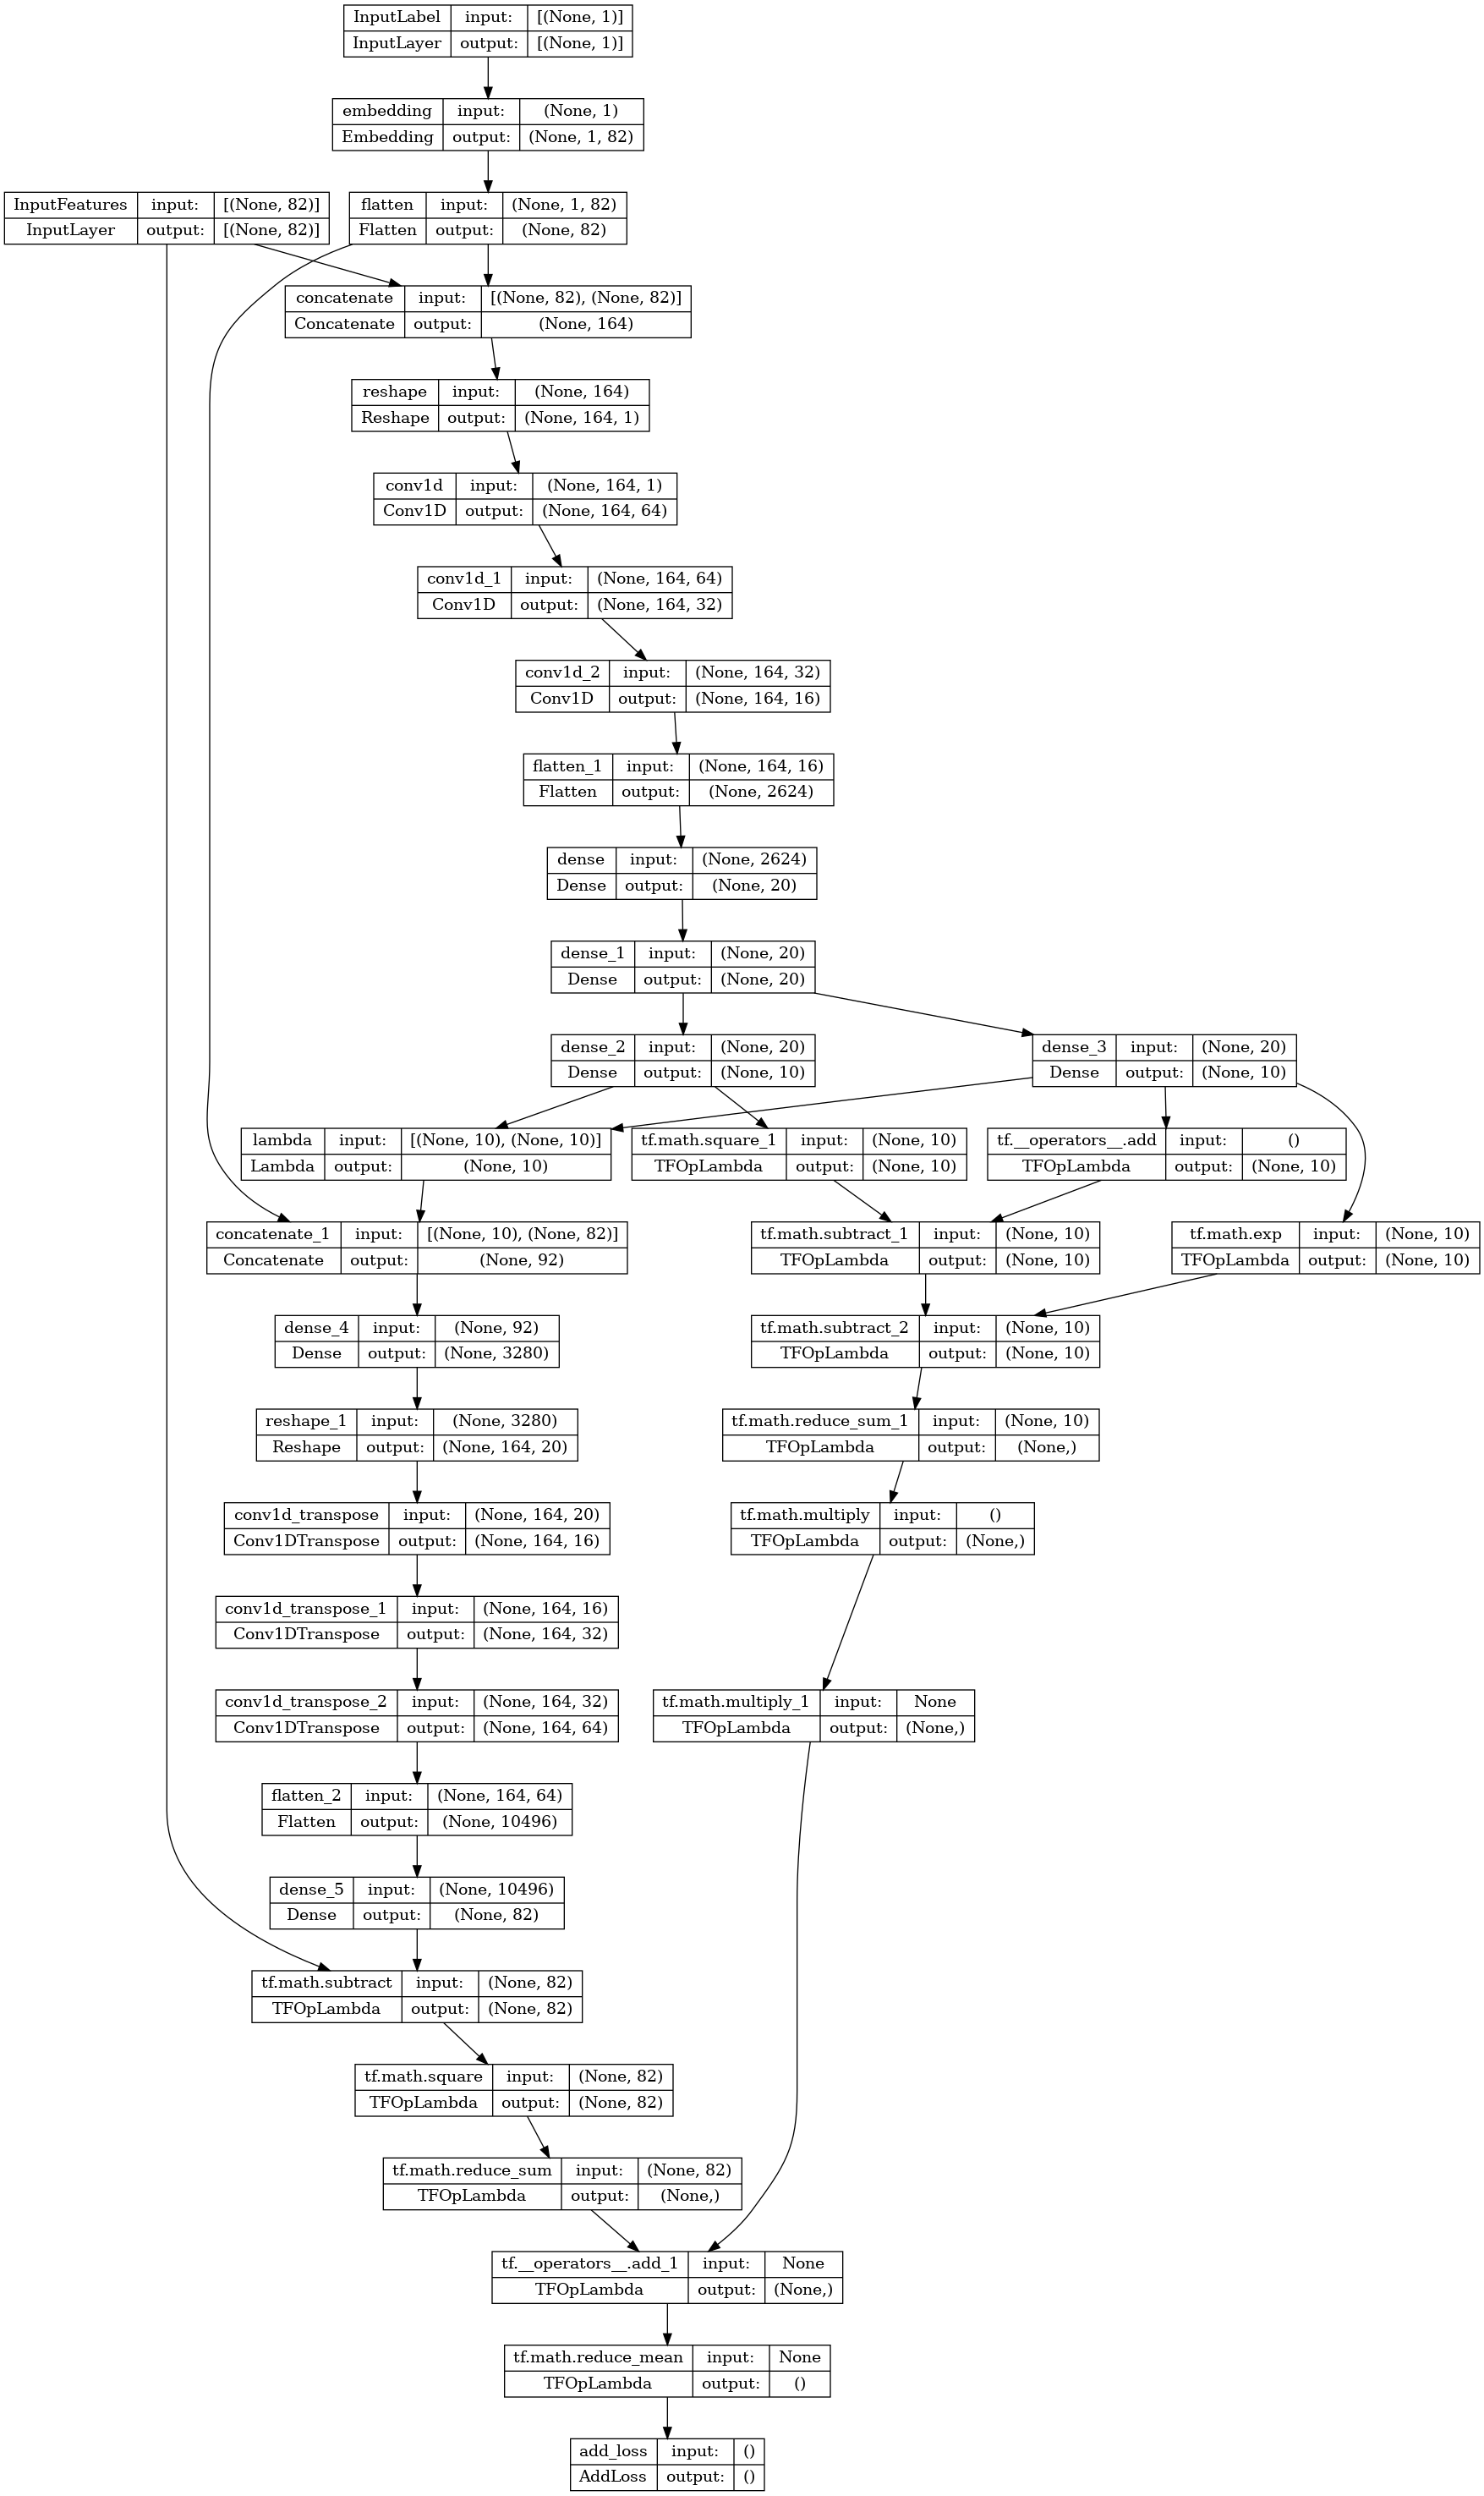

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

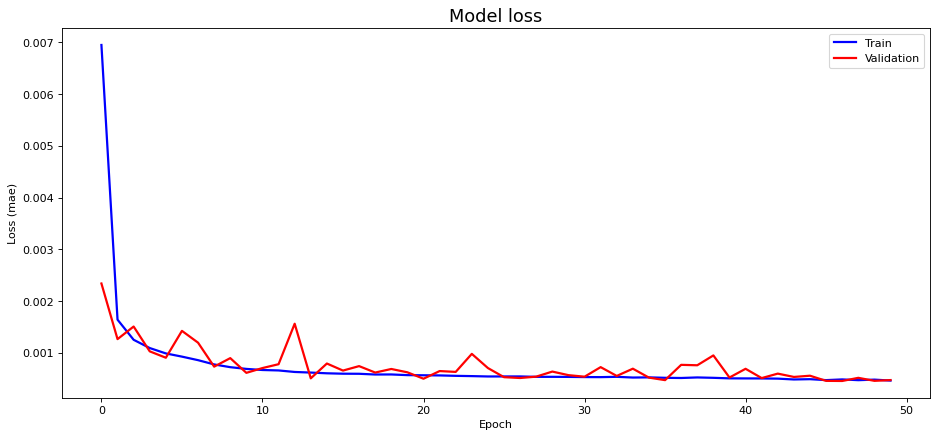

In [29]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [30]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [31]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

5481/5481 [==============================] - 11s 2ms/step


In [32]:
error_df

,reconstruction_error,true_class
0,0.000629,1
1,0.000230,0
2,0.000239,0
3,0.000028,0
4,0.000283,0
...,...,...
175356,0.000315,0
175357,0.000250,0
175358,0.000634,0
175359,0.000608,1


In [33]:

error_df['log_error'] = np.log1p(error_df['reconstruction_error'])  # log(1 + x)를 사용해 0인 값을 처리

In [34]:
error_df['log_error']

0         0.000629
1         0.000230
2         0.000239
3         0.000028
4         0.000282
            ...   
175356    0.000315
175357    0.000250
175358    0.000634
175359    0.000608
175360    0.000217
Name: log_error, Length: 175361, dtype: float64

In [35]:
error_df['true_class'].value_counts()

0    159751
1     15610
Name: true_class, dtype: int64

In [36]:
error_df[error_df['true_class']==0].max()

reconstruction_error    0.024162
true_class              0.000000
log_error               0.023874
dtype: float64

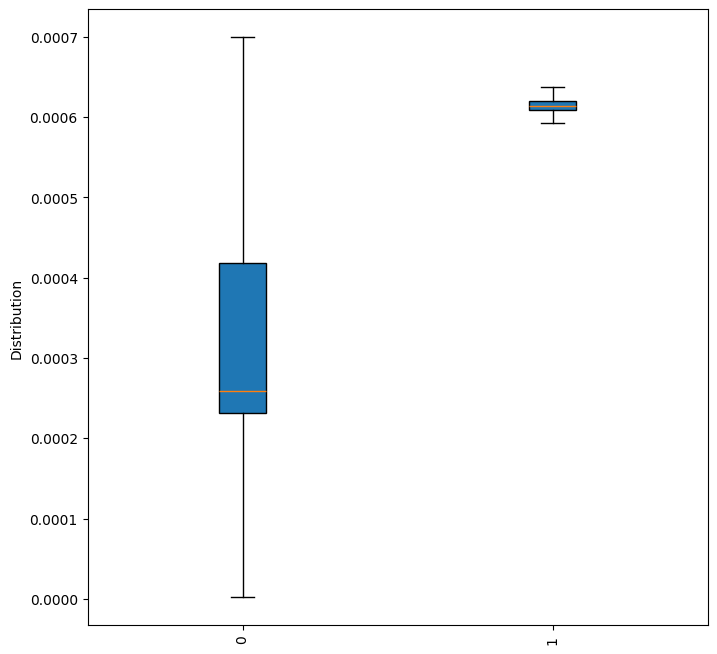

In [38]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


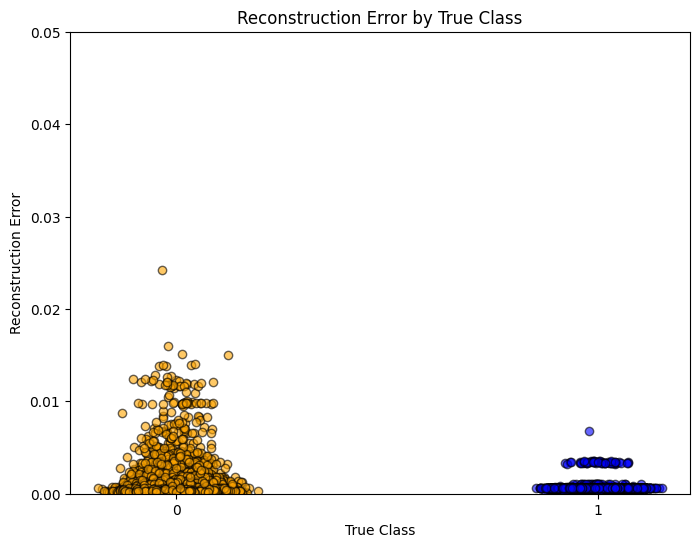

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 0.05)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


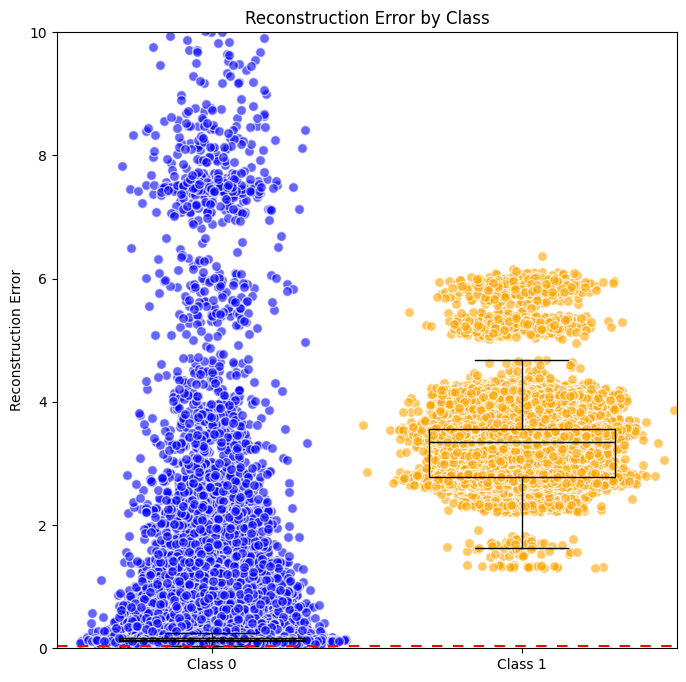

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 11]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=10)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


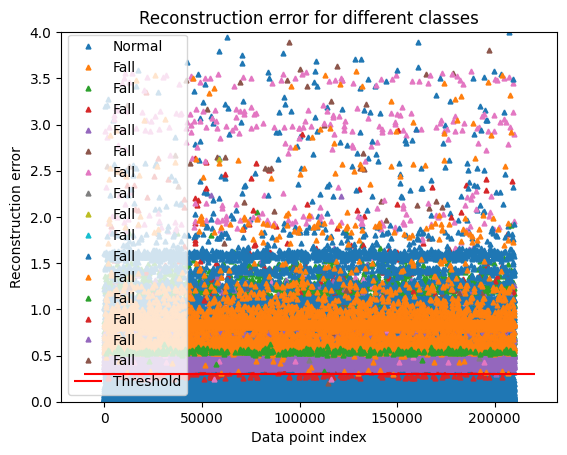

In [43]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 4)
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

<Figure size 1200x1200 with 0 Axes>

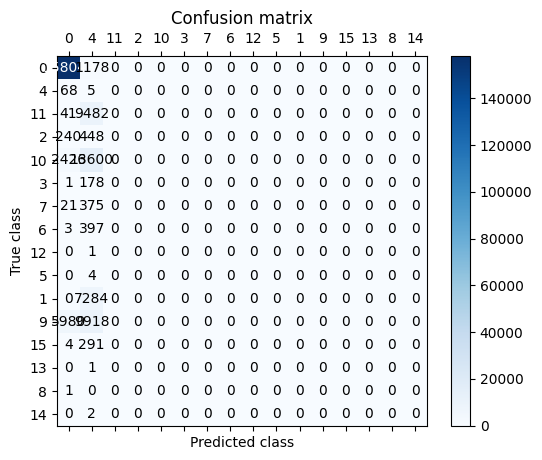

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Class 0: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 4: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 11: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 2: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 10: Precision=0.0592, Recall=0.0663, F1-Score=0.0606


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Class 3: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 7: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 6: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 12: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 5: Precision=0.0592, Recall=0.0663, F1-Score=0.0606


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Class 1: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 9: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 15: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 13: Precision=0.0592, Recall=0.0663, F1-Score=0.0606
Class 8: Precision=0.0592, Recall=0.0663, F1-Score=0.0606


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 14: Precision=0.0592, Recall=0.0663, F1-Score=0.0606


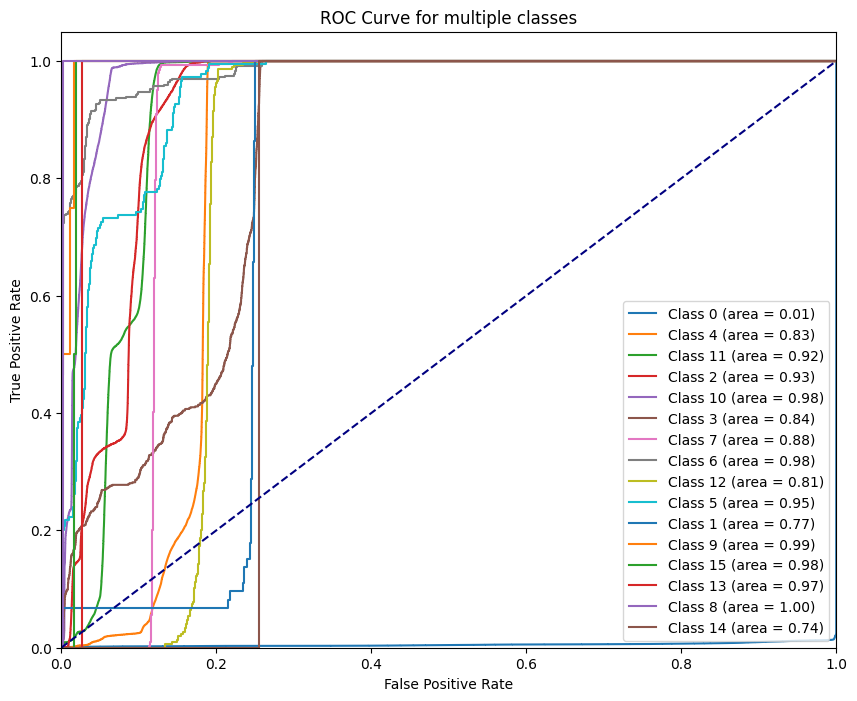

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc

# 임계값을 각 클래스별로 수동으로 설정
thresholds = {
    0: 0.5,   # 임의의 값, 직접 설정
    4: 0.4,   # 임의의 값, 직접 설정
    11: 0.6,  # 임의의 값, 직접 설정
    2: 0.5,   # 임의의 값, 직접 설정
    10: 0.5,  # 임의의 값, 직접 설정
    3: 0.4,   # 임의의 값, 직접 설정
    7: 0.6,   # 임의의 값, 직접 설정
    6: 0.7,   # 임의의 값, 직접 설정
    12: 0.5,  # 임의의 값, 직접 설정
    5: 0.3,   # 임의의 값, 직접 설정
    1: 0.6,   # 임의의 값, 직접 설정
    9: 0.5,   # 임의의 값, 직접 설정
    15: 0.7,  # 임의의 값, 직접 설정
    13: 0.8,  # 임의의 값, 직접 설정
    8: 0.6,   # 임의의 값, 직접 설정
    14: 0.4   # 임의의 값, 직접 설정
}

# 각 클래스에 대해 예측 및 성능 평가
precision_scores = {}
recall_scores = {}
f1_scores = {}

# true_class가 0부터 15까지인 데이터만 필터링
filtered_df = error_df[error_df['true_class'].isin(thresholds.keys())]

# 예측값을 저장할 리스트
y_pred = np.zeros(len(filtered_df), dtype=int)

# 클래스별 임계값에 따라 예측값 생성
for class_id in thresholds.keys():
    idx = filtered_df[filtered_df['true_class'] == class_id].index
    y_pred[idx] = np.array([1 if filtered_df.loc[i, 'reconstruction_error'] >= thresholds[class_id] else 0 for i in idx])

# 혼동행렬 생성
conf_matrix = confusion_matrix(filtered_df.true_class, y_pred)

# 혼동행렬 시각화
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# 혼동행렬 플롯
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar(cax)

ax.set_xticks(np.arange(len(thresholds)))
ax.set_yticks(np.arange(len(thresholds)))

ax.set_xticklabels(thresholds.keys())
ax.set_yticklabels(thresholds.keys())

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# 혼동행렬 수치 삽입
for i in range(len(thresholds)):
    for j in range(len(thresholds)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

# 클래스별 precision, recall, fscore 계산 및 저장
for class_id in thresholds.keys():
    idx = filtered_df['true_class'] == class_id
    precision, recall, f1, _ = precision_recall_fscore_support(filtered_df['true_class'], y_pred, average='macro')  # 'binary' -> 'macro'로 수정
    precision_scores[class_id] = precision
    recall_scores[class_id] = recall
    f1_scores[class_id] = f1

    print(f'Class {class_id}: Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

# ROC 곡선 그리기
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for class_id in thresholds.keys():
    idx = filtered_df['true_class'] == class_id
    fpr[class_id], tpr[class_id], _ = roc_curve(idx, filtered_df['reconstruction_error'])
    roc_auc[class_id] = auc(fpr[class_id], tpr[class_id])

    # 각 클래스의 ROC 곡선 그리기
    plt.plot(fpr[class_id], tpr[class_id], label=f'Class {class_id} (area = {roc_auc[class_id]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for multiple classes')
plt.legend(loc="lower right")
plt.show()

In [54]:
print(f"ROC Score : {roc_auc}")

ROC Score : {0: 0.00519061061134957, 4: 0.8302478322755422, 11: 0.9202085526037351, 2: 0.9251516187330842, 10: 0.9762921168529437, 3: 0.838935204320286, 7: 0.8795979207816869, 6: 0.9823276659303987, 12: 0.8132952520340107, 5: 0.947023613142916, 1: 0.7710030816615848, 9: 0.9929474175452632, 15: 0.9824377607192518, 13: 0.9733900960489912, 8: 0.9978475882988804, 14: 0.7448820697438534}


In [53]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.980261716778255
Precision: 0.9245210867506738
Recall: 1.0
F1 Score: 0.960780417648339
